In [1]:
import torch
from torch import nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.nn.init import zeros_, ones_, constant_
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Load Data

In [15]:
path = "../../data/CDS_2021_01/data.npz"
d = torch.from_numpy(np.load(path, mmap_mode="r")['input_raw_data'])[:,:,::2,::2] # downsample resolution


In [16]:
N = d.shape[0]
s1 = d.shape[2]
s2 = d.shape[3]
L = d.shape[1] * d.shape[2] * d.shape[3]
print(d.shape)
d = d.reshape((N,L)).T

torch.Size([124, 7, 360, 720])


In [224]:
import gc

def POD(a):
  U,S,Vt = torch.linalg.svd(a,full_matrices=False) # LN
  modes = U # LM
  scale = torch.sum(S**2)
  PVE = S**2 / scale
  return modes, PVE.numpy(), scale

def POD_break(a,steps=10,acc=0.99):
  items = []
  for i in range(steps):
    ai = a[:,i*steps:(i+1)*steps]
    U,S,Vt = torch.linalg.svd(ai,full_matrices=False)

    eig = S**2

    PVE = torch.cumsum(eig[1:], dim=0) / torch.sum(eig[1:]) # make sure to skip mean
    try:
      q = min(torch.where(PVE > acc)[0][0] + 1, len(eig))
    except IndexError:
      q = 1 # first is sufficient

    # print(q, PVE[q])


    # print(U.shape, S.shape)
    items.append(U[:,:q]@torch.diag(S[:q])) # LM MM

  data = torch.cat(items, dim=1)
  U,S,Vt = torch.linalg.svd(data,full_matrices=False)

  modes = U #@ torch.diag(S) # weighted modes
  gc.collect()
  return modes

def PVE(a, modes, scale):
  # assumes orth. modes
  al = modes.T @ a# a@a.T expected to be QLQt # LL
  L = al @ al.T # expected to be diagonal with upper matrices having trace = cum PVE

  # in case not diagonal do eigendecomp:
  PVE = torch.flip(torch.linalg.eigvalsh(L),dims=(0,)) / scale

  isolated_PVE = torch.diagonal(L,0) / scale

  return isolated_PVE.numpy(), PVE.numpy()





In [259]:
modes,_,_ = POD(d) # POD_break(d,steps=20,acc=0.99)


In [260]:
modes.shape

torch.Size([1814400, 124])

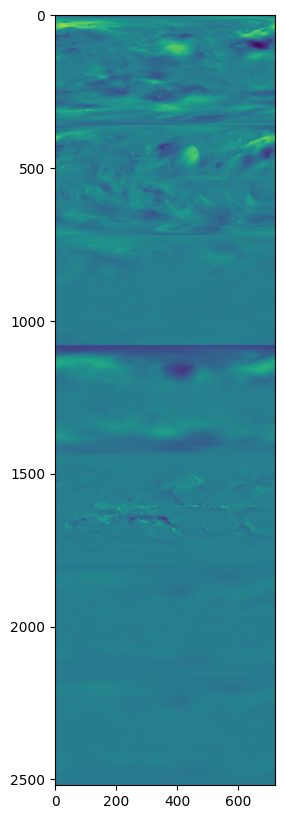

In [261]:
plt.figure(figsize=(10,10))
plt.imshow(modes[:,1].reshape((-1,s2)))

In [277]:
class DMD_DF_Net(nn.Module):
    def __init__(self,m, length):
        super().__init__()
        
        self.length=length
        
        self.m = m
        self.rot = Parameter(torch.eye(m).to(torch.cfloat))
        self.diagonal = Parameter(torch.zeros(m))
        self.I = torch.eye(m).to(torch.cfloat).cuda()

    def forward(self,x):
        # x is sequence (L,N)
        # u_pre = (self.modes.T@x).to(torch.cfloat) # (m,L) @ (L,N) = (m,N)
        u_pre = x.to(torch.cfloat)
        
        u = self.rot@u_pre # (m,m) @ (m,N) = (m,N)
        # u = torch.linalg.multi_dot([self.rot.T,self.modes.T,x]) # (m,m) @ (m,L) @ (L,N) = (m,N)

        sc = (1j * self.diagonal) + 1 # (m)
        self.scm = torch.cumprod(torch.stack([sc for i in range(self.length)],dim=1),dim=1) # (m,N)
              
        uc = u
        for i in range(x.shape[1]):
            u2 = torch.sum(uc * self.scm, dim=1) # (m)
            uc = torch.cat([uc[:,1:],u2.unsqueeze(1)],dim=1)
        
        # x2 = torch.linalg.multi_dot([self.modes, self.rot, uc]) # (L,N)
        x2_pre = (self.rot@uc).to(torch.double) # (m,N)
        # x2 = self.modes@x2_pre # (L,m) @ (m,N) = (L,N)
        x2 = x2_pre # (m,N)
        
        return x2
    
    def mode_matrix_loss(self, lf):
        a1 = self.rot @ self.rot.T
        a2 = self.rot.T @ self.rot
        return lf(a1.real,self.I.real) + lf(a2.real,self.I.real) + lf(a1.imag,self.I.imag) + lf(a2.imag,self.I.imag)
    
class DMD_Net(nn.Module):
    def __init__(self, m, length):
        super().__init__()
        
        self.length=length
        
        self.m = m
        self.A = Parameter(torch.eye(m).repeat(length,1,1).to(torch.cfloat))

    def forward(self,x):
        # x is sequence (L,N)
        # u_pre = (self.modes.T@x).to(torch.cfloat) # (m,L) @ (L,N) = (m,N)
        u_pre = x.to(torch.cfloat)
        
        u = u_pre # (m,m) @ (m,N) = (m,N)
        # u = torch.linalg.multi_dot([self.rot.T,self.modes.T,x]) # (m,m) @ (m,L) @ (L,N) = (m,N)

              
        uc = u
        for i in range(x.shape[1]): # prediction loop
            u2 = torch.zeros_like(uc[:,0])
            for j in range(x.shape[1]):
                u2 += self.A[j] @ uc[:,-j] # (m)
            uc = torch.cat([uc[:,1:],u2.unsqueeze(1)],dim=1)
        
        # x2 = torch.linalg.multi_dot([self.modes, self.rot, uc]) # (L,N)
        x2_pre = uc.to(torch.double) #(self.rot@uc).to(torch.double) # (m,N)
        # x2 = self.modes@x2_pre # (L,m) @ (m,N) = (L,N)
        x2 = x2_pre # (m,N)
        
        return x2

 

In [284]:
       
    
def step(net, x1, x2, opt, lf, length):
    
    opt.zero_grad()
    x2hat = net(x1)
    loss = lf(x2hat,x2)/length #+ net.mode_matrix_loss(lf)
    ls = loss.item()
    loss.backward()
    opt.step()
    
    return ls

m=20
ilength = 10
length = 2*ilength
net = DMD_Net(m=m,length=ilength).cuda()
mcpu = modes[:,:m]
opt = torch.optim.Adam(net.parameters(),lr=0.0005) # lower lr for greater length
lf = nn.MSELoss()
dgpu = u_pre = (mcpu.T @ d).cuda()



100%|██████████| 10000/10000 [06:01<00:00, 27.69it/s]


In [292]:

losses = []
for i in tqdm(range(20000)):
    a = i % (d.shape[1] - length)
    c = a + length//2
    b = a + length

    loss = step(net, dgpu[:,a:c], dgpu[:,c:b], opt, lf, length)
    # print(loss)
    losses.append(loss)



100%|██████████| 20000/20000 [12:04<00:00, 27.61it/s]


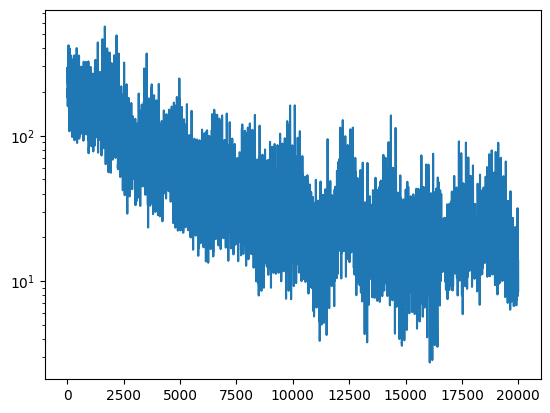

In [293]:
plt.plot(losses) # 50k steps
plt.yscale('log')

In [296]:
q=30
outs = (mcpu @ net.forward(dgpu[:,q:q+ilength]).detach().cpu()).numpy()


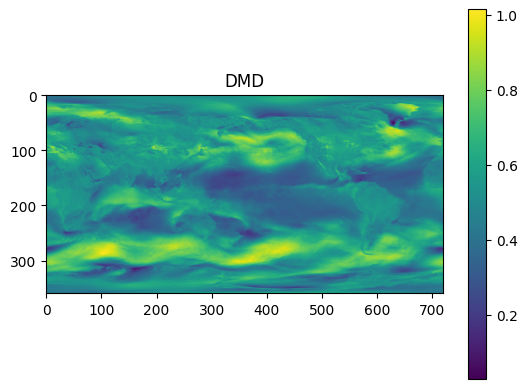

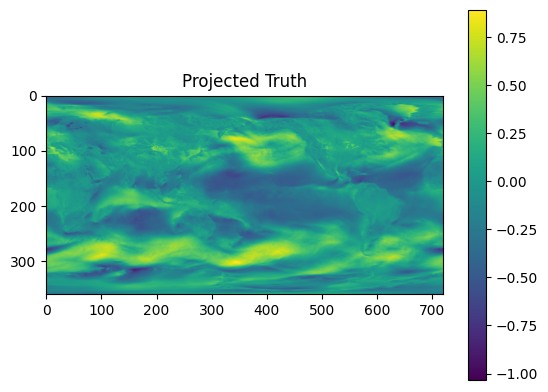

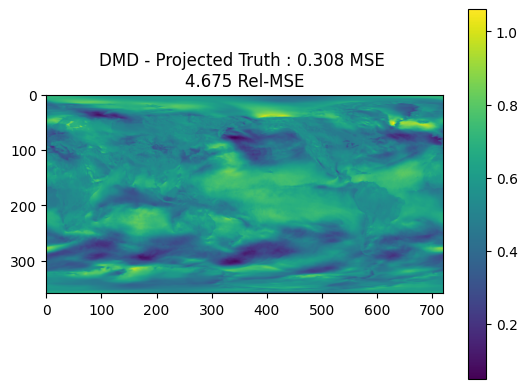

Text(0.5, 1.0, 'DMD - Truth : 0.317 MSE \n4.339 Rel-MSE')

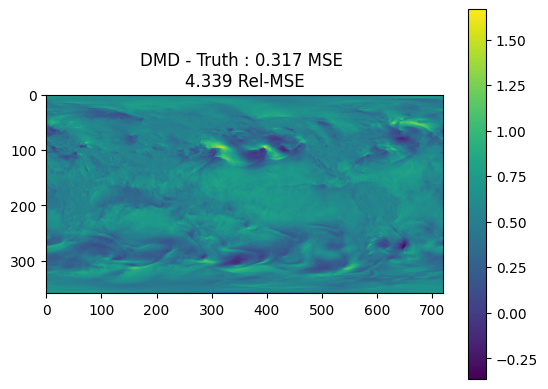

In [311]:

i=8
j=0
a = outs[:,i].reshape((-1,s1,s2))[j]
b = (mcpu @ dgpu[:,q+ilength+i].detach().cpu()).reshape((-1,s1,s2))[j].numpy()
bt = d[:,q+ilength+i].reshape((-1,s1,s2))[j].numpy()
# c = (mcpu @ dgpu[:,q+ilength-1].detach().cpu()).reshape((-1,s1,s2))[j].numpy()
mx = np.max(b)
mn = np.min(b)
a = (a - mn) / (mx - mn)

im = plt.imshow(a)
plt.colorbar(im)
plt.title("DMD")
plt.show()
im = plt.imshow(b)
plt.colorbar(im)
plt.title("Projected Truth")
plt.show()
im = plt.imshow(a-b)
plt.colorbar(im)
plt.title(f"DMD - Projected Truth : {np.mean((a-b)**2):.3f} MSE \n{np.mean((a-b)**2)/np.mean(b**2):.3f} Rel-MSE")
plt.show()
im = plt.imshow(a-bt)
plt.colorbar(im)
plt.title(f"DMD - Truth : {np.mean((a-bt)**2):.3f} MSE \n{np.mean((a-bt)**2)/np.mean(bt**2):.3f} Rel-MSE")